# Load Bike Datasets  from https://s3.amazonaws.com/tripdata/index.html

In [41]:
# Quelques trou: 
# - Le 2 février 2021 
# - Le 21 Aout 2021
# - Un usage bien différent du vélo des français: utilisation principalement lors de période plus chaude. Non utilisé en hiver.

import os 
import glob 
import pandas as pd
import geopandas as gpd
from shapely import Point
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt

from load_inputs.systematic_analysis.utils import get_histogram_per_day_type,get_boxplot_per_spatial_unit_per_day_type,heatmap
from load_inputs.systematic_analysis.utils import IN_bdc,OUT_bdc,IN_nbdc,OUT_nbdc

ROOT = '../../../../data/rrochas'
FOLDER_PATH = f'{ROOT}/raw_data/Manhattan'
SAVE_PATH = f'{ROOT}/prediction_validation/Manhattan'



local_folder_path = '../../../../data/rrochas/prediction_validation/Manhattan/'

freq = '1h'  # '15min' # '1h' # '30min
All_df_pivoted_bike = []
All_nb_bike_stations = []
year_min = 2021
year_max = 2022
month_min = 11 # None 
month_max = 12 # None 
for year in range(year_min,year_max+1):
    if year == year_min:
        month_min_i = month_min
        month_max_i = 13
    elif year == year_max:
        month_min_i = 1
        month_max_i = month_max + 1
    else:
        month_min_i = 1
        month_max_i = 13
    for month in range(month_min_i,month_max_i):
        # 01_15min_emitted.csv
        path = f"{SAVE_PATH}/city_bike_{year}/{month:02d}_{freq}_emitted.csv"
        df_bike = pd.read_csv(path,index_col=0,dtype={0: str, 1:str, 2:int}) # specify columns dtypes
        df_bike = df_bike.rename(columns={'starttime': 'started_at', 'stoptime': 'ended_at'})
        df_bike.index.name ='start_station_id'
        df_bike['started_at'] = pd.to_datetime(df_bike['started_at'])
        nb_bike_stations = df_bike.index.nunique()

        # Pivoted bike:
        df_pivoted_bike_i = df_bike.reset_index().pivot_table(index='started_at', columns='start_station_id', values='Flow').fillna(0).sort_index()
        df_pivoted_bike_i = df_pivoted_bike_i[df_pivoted_bike_i.index > datetime(year,month,1)]

        All_df_pivoted_bike.append(df_pivoted_bike_i)
        All_nb_bike_stations.append(nb_bike_stations)

# Concatenate all pivoted bike dataframes:
pivoted_bike = pd.concat(All_df_pivoted_bike).sort_index().copy()
pivoted_bike = pivoted_bike.fillna(0)
print(f"Total number of active bike stations per month:")
for month, nb_stations in enumerate(All_nb_bike_stations, start=1):
    print(f"Year {2021 + (month-1)//12} Month {(month%12):02d}: {nb_stations} stations")

print(f"Total number of unique bike stations across all months: {pivoted_bike.columns.nunique()}")

Total number of active bike stations per month:
Year 2021 Month 01: 1575 stations
Year 2021 Month 02: 1583 stations
Year 2021 Month 03: 1596 stations
Year 2021 Month 04: 1615 stations
Year 2021 Month 05: 1613 stations
Year 2021 Month 06: 1615 stations
Year 2021 Month 07: 1620 stations
Year 2021 Month 08: 1633 stations
Year 2021 Month 09: 1654 stations
Year 2021 Month 10: 1665 stations
Year 2021 Month 11: 1695 stations
Year 2021 Month 00: 1713 stations
Year 2022 Month 01: 1743 stations
Year 2022 Month 02: 1767 stations
Total number of unique bike stations across all months: 1842


# Filter Inactive Bike: 

In [51]:
THRESHOLD_MIN =  0.854 #0.854 #1
if False:
    number_of_month_in_period = ((13-month_min)+ (month_max) + (year_max-1-year_min)*12)
    threshold_period = THRESHOLD_MIN*24* number_of_month_in_period*30

    print(f"number_of_month_in_period: {number_of_month_in_period}")
    print(f"threshold_period: {threshold_period}")

    mask = (pivoted_bike.sum() > threshold_period)


mask = pivoted_bike.mean() > THRESHOLD_MIN
print(f"Number of stations with mean flow > {THRESHOLD_MIN}: {mask.sum()} out of {len(mask)}")
pivoted_bike =  pivoted_bike[mask[mask].index]

Number of stations with mean flow > 0.854: 833 out of 833


# EDA Bike Dataset:

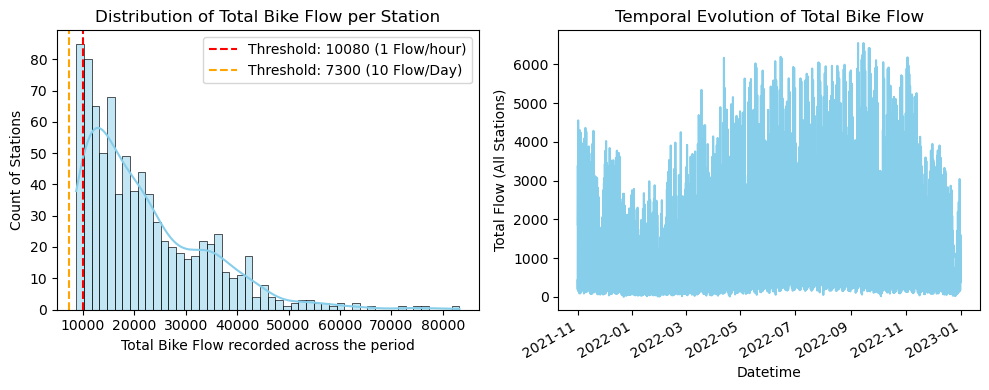

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Plot 1: Distribution (Somme par station / Colonnes) ---
sns.histplot(pivoted_bike.sum(), bins=50, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Total Bike Flow per Station')
axes[0].set_xlabel('Total Bike Flow recorded across the period')
axes[0].set_ylabel('Count of Stations')
# Set a vertical line related to the number of stations with more than 1 Flow per hour (i.e > 365*2*24 for a period of 2 years)
threshold = 365 * (year_max+1-year_min) * 24 if month_min is None and month_max is None else threshold_period
axes[0].axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold} (1 Flow/hour)')
threshold = 365 * (year_max+1-year_min) * 10 
axes[0].axvline(threshold, color='orange', linestyle='--', label=f'Threshold: {threshold} (10 Flow/Day)')
# display legend for the vertical line
axes[0].legend()
# --- Plot 2: Évolution Temporelle (Somme par timestamp / Lignes) ---
# On utilise sum(axis=1) pour sommer toutes les stations à chaque heure
pivoted_bike.sum(axis = 1).plot(ax=axes[1], color='skyblue')
axes[1].set_title('Temporal Evolution of Total Bike Flow')
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Total Flow (All Stations)')

# Ajuste automatiquement l'espacement entre les subplots
plt.tight_layout()
plt.show()

Number of remaining time-slots after filtering 6973
Number of remaining time-slots after filtering 3236


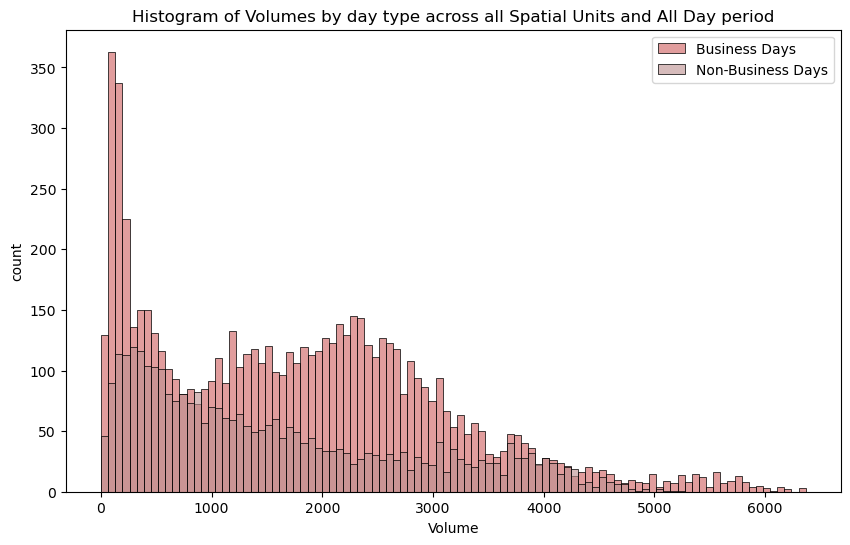

Number of remaining time-slots after filtering 1164
Number of remaining time-slots after filtering 540


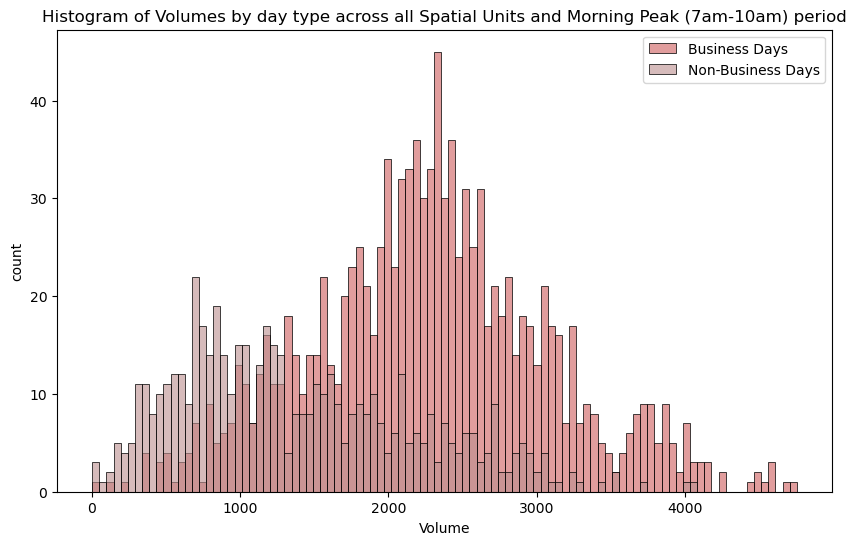

Number of remaining time-slots after filtering 873
Number of remaining time-slots after filtering 405


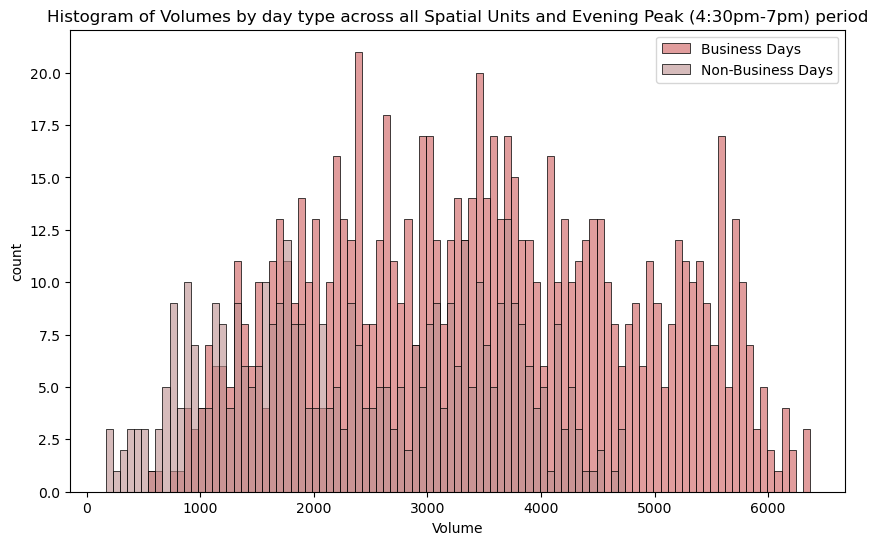

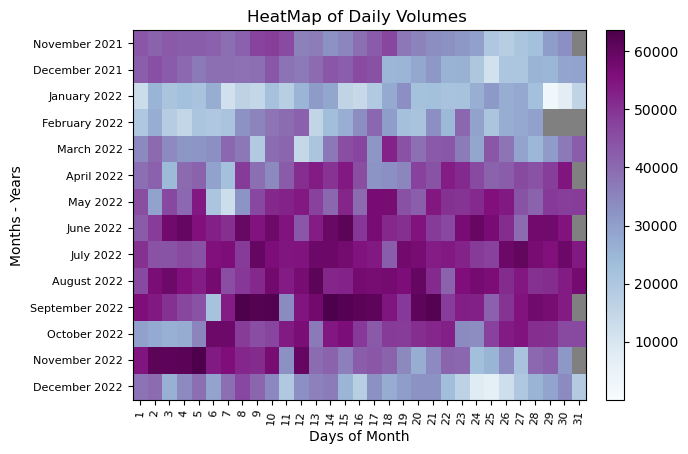

In [34]:
from load_inputs.systematic_analysis.utils import get_histogram_per_day_type,get_boxplot_per_spatial_unit_per_day_type,heatmap
from load_inputs.systematic_analysis.utils import IN_bdc,OUT_bdc,IN_nbdc,OUT_nbdc

stats = 'count'
signal = 'out'
mode = 'manhattan_bike'
city = 'Manhattan'
df_raw = pivoted_bike.copy()
palette = [OUT_bdc, OUT_nbdc]


# ==== Histogram ====
for period in ['all_day','morning_peak','evening_peak']:
    folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/{mode}"
    save_path = f'{folder}/{mode}_hist_{signal}_{period}.pdf'# None 
    ts_bd, ts_nbd = get_histogram_per_day_type(df_raw,city= city,period = period,stats = stats, palette = palette,n_bins = 100,save_path= save_path)

# ==== Boxplot ====
if False: 
    # Too much stations -> impossible to use: 
    df_raw.columns.name = 'Spatial Unit ID'
    for period in ['all_day','morning_peak','evening_peak']:
        folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/{mode}_boxplot"
        save_path = f'{folder}/{mode}_boxplot_{signal}_{period}.pdf'# None
        df_bd, df_nbd = get_boxplot_per_spatial_unit_per_day_type(df_raw,period = period,city= city, palette = palette,save_path = save_path,df_all = df_raw)

# ==== HeatMap ====
cmap = 'BuPu' # 'hot' #'YlOrRd' # 'RdYlBu'
bool_reversed= False 
folder = f"../../../home/rrochas/prediction-validation/load_inputs/systematic_analysis/plots/{mode}/{mode}_heatmap"

save_path = f'{folder}/{mode}_heatmap_{city}.pdf'# None
df_agg = heatmap(df_raw,city= city,cmap = cmap,bool_reversed = bool_reversed,
                 save_path = save_path )